In [65]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

Data initializations

In [66]:
np.random.seed(42)
n_samples = 1000
k_classes = 2
g1_precentage = 0.7
g2_precentage = 0.3

Ganerating data

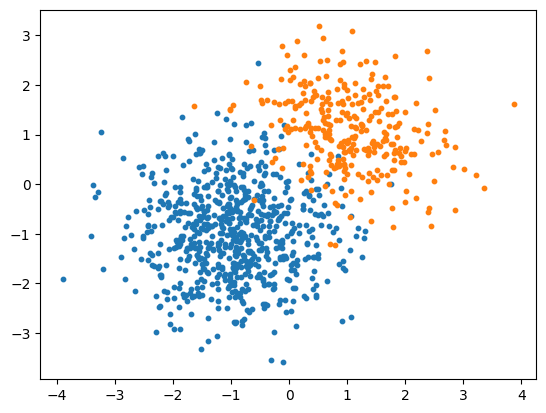

In [67]:
real_u1 = np.array([-1, -1])
real_sigma1 = np.array([[0.8, 0], [0, 0.8]])

real_u2 = np.array([1, 1])
real_sigma2 = np.array([[0.75, -0.2], [-0.2, 0.6]])

X1 = np.random.multivariate_normal(real_u1, real_sigma1, int(n_samples * g1_precentage))
X2 = np.random.multivariate_normal(real_u2, real_sigma2, int(n_samples * g2_precentage))
X = np.concatenate((X1, X2), axis=0)

plt.scatter(X1[:, :-1], X1[:, -1], s=10)
plt.scatter(X2[:, :-1], X2[:, -1], s=10)
plt.show()

In [68]:
np.random.shuffle(X)

means, sigma and pi initializations

In [69]:
means_init_method = 'furthest point' # options: random point(Default), random space, furthest point
sigma_init_method = 'std' # options: I(Defualt), std

u_means = np.zeros((k_classes, X.shape[1]))
sigma = np.full_like(np.zeros((k_classes, X.shape[1], X.shape[1])), fill_value=np.eye(X.shape[1]))
pi = np.ones((k_classes,)) / k_classes

if (means_init_method == 'random space'):    
    X_space_max = np.max(X, axis=0)
    X_space_min = np.min(X, axis=0)
    u_means = (np.random.rand(k_classes, X.shape[1]) * (X_space_max - X_space_min)) + X_space_min
elif (means_init_method == 'furthest point'):
    u_means[0] = X[np.random.randint(0, n_samples), :]
    for k in range(k_classes - 1):
        dist = np.zeros((n_samples, 1))
        for i in range(k + 1):
            dist += np.sum((X - u_means[i]) ** 2, axis=1).reshape((n_samples, 1))
        u_means[k + 1] = X[np.argmax(dist), :]
else:
    u_means = X[np.random.randint(0, n_samples, (2)), :]

if (sigma_init_method == 'std'):
    sigma = sigma * np.std(X, axis=0)
    
init_means = u_means

print("initial means: \n", u_means)
print("\ninitial sigma: \n", sigma)

initial means: 
 [[-2.71620115 -1.02371473]
 [ 3.86871732  1.60510803]]

initial sigma: 
 [[[1.24674466 0.        ]
  [0.         1.28339527]]

 [[1.24674466 0.        ]
  [0.         1.28339527]]]


Initial state:

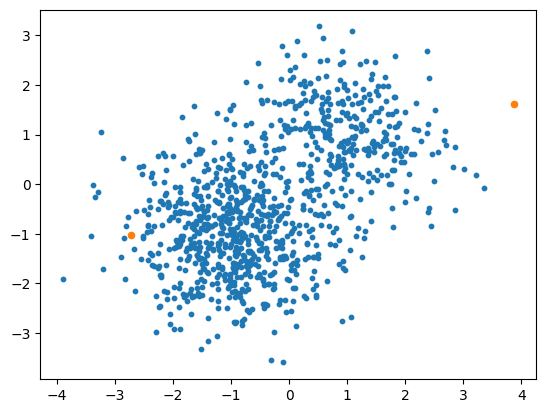

In [70]:
plt.scatter(X[:, :-1], X[:, -1], s=10)
plt.scatter(u_means[:, 0], u_means[:, 1], s=20)
plt.show()

the algorithem(GMM):

In [71]:
max_iter = 100
epsilon_0 = 1e-8
epsilon_diff = 1e-3
w = np.zeros((n_samples, k_classes))

converge = max_iter

for k in range(max_iter):
    last_u = u_means
    last_sigma = sigma
    
    xproba = np.zeros((n_samples,))
    
    for j in range(k_classes):
        jguessian = multivariate_normal(u_means[j], sigma[j])
        jproba = jguessian.pdf(X)
        w[:, j] = jproba * pi[j] 
        xproba += w[:, j]
    w = w / (xproba.reshape((n_samples, 1)) + epsilon_0)
    
    pi = np.mean(w, axis=0)
    u_means = (np.transpose(w) @ X) / ((pi.reshape((k_classes, 1)) * n_samples) + epsilon_0)
    
    if (np.max(np.sum(np.abs(u_means - last_u), axis=1)) < epsilon_diff and np.max(np.sum(np.sum(np.abs(sigma - last_sigma)))) < epsilon_diff):
        converge = k
        break
    
    for j in range(k_classes):
        sigma[j] = np.transpose(w[:, j].reshape((n_samples, 1)) * (X - u_means[j])) @ (X - u_means[j])
        sigma[j] = sigma[j] / ((n_samples * pi[j]) + epsilon_0)
        
if (converge == max_iter):
    print("algorithem reached its max iteration")
else:
    print("algorithem converged after ", converge, "iterations")
print("GMM means: \n", u_means)

algorithem converged after  22 iterations
GMM means: 
 [[-0.97000795 -0.98387003]
 [ 1.00477868  1.07102748]]


Calculate model prediction for the data:

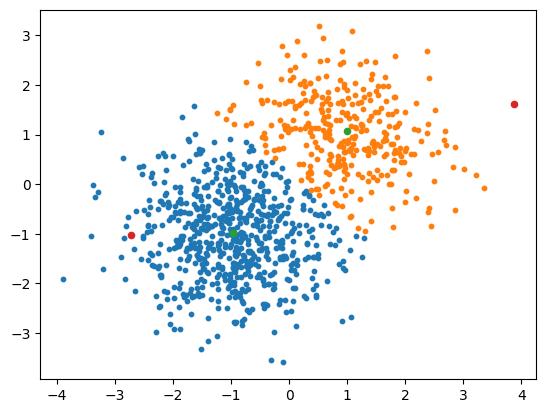

In [72]:
X_pred = np.array((k_classes, 1), dtype=object)
found = np.zeros((k_classes,), dtype=bool)
guessians = np.empty((k_classes,), dtype=object)
proba = np.zeros((k_classes, n_samples))

for k in range(k_classes):
    guessians[k] = multivariate_normal(u_means[k], sigma[k])
    proba[k] = guessians[k].pdf(X)

max_index = np.argmax(proba, axis=0)

for i in range(n_samples):
    if not found[max_index[i]]:
        X_pred[max_index[i]] = X[i, :].reshape(1, X.shape[1])
        found[max_index[i]] = True
    else:
        X_pred[max_index[i]] = np.concatenate((X_pred[max_index[i]], X[i, :].reshape((1, X.shape[1]))), axis=0)

for k in range(k_classes):
    plt.scatter(X_pred[k][:, 0], X_pred[k][:, 1], s=10) # group points
plt.scatter(u_means[:, :-1], u_means[:, -1], s=20) # model means
plt.scatter(init_means[:, :-1], init_means[:, -1], s=20) # initial means
plt.show()

Convergance Stabillity results(average of 1000 tests each):

            mean\sigma     |       I        |     std     |
        |   random point   |     58.34      |    43.469   |
        |   random space   |     46.441     |    54.486   |
        |  furthest point  |     42.027     |    33.74    |

Conclusions:

the GMM algorithem highly depends on the initial conditions.

because of that, its hard to know which initilazation method is better.
(meaning even the "best" initialazation for this data can get a "bad" random and vise versa)

this is why in the stabillity testing we used a high number of tries per method(but even that wasnt very consistent).

The mean convergance of the random space initializion was the most volotyle.
We did notice that in general the furthest point method was the most stable and converged in the least amount of iterations on average of all of the initilaztion methods we tested.

The std usally improved but sometimes deproved(especially on random space).